## **Install**

In [2]:
!pip install numpy==1.26.0
!pip install pandas==2.2.1
!pip install seaborn==0.13.2
!pip install matplotlib==3.8.3
!pip install scikit-learn==1.4.1.post1
!pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.1 kB 640.0 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.1 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 61.1/61.1 kB 466.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.5 MB 3.4 MB/s eta 0:00:05
    --------------------------------------- 0.2/15.5 MB 3.0 MB/s eta 0:00:06
    --------------------------------------- 0.4/15.5 MB 2.8 MB/s eta 0:00:06
   - -------------------------------------- 0.5/15.5 MB 3.3 MB/s eta 0:00:05
   - -------------------------------------- 0.7/15.5 MB 3.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.9/15.5 MB 3.6 MB/s eta 0:00:05
   -- ------------------------------------- 1.1/15.5 MB 3.8 MB/s eta 0:00:04
 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.5 MB 2.0 MB/s eta 0:00:06
   ---------------------------------------- 0.1/11.5 MB 1.7 MB/s eta 0:00:07
    --------------------------------------- 0.2/11.5 MB 2.0 MB/s eta 0:00:06
   - -------------------------------------- 0.3/11.5 MB 1.9 MB/s eta 0:00:06
   - -------------------------------------- 0.5/11.5 MB 2.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/11.5 MB 2.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.9/11.5 MB 2.9 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/11.5 MB 2.7 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/11.5 MB 3.2 MB/s eta 0:00:04
   ----- ---------------------------------- 1.5/11.5 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.7/11.5 MB 3.6 MB/s eta 0:00:03
   --

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB 145.2 kB/s eta 0:00:53
   ---------------------------------------- 0.1/7.6 MB 217.9 kB/s eta 0:00:35
   ---------------------------------------- 0.1/7.6 MB 261.4 kB/s eta 0:00:29
   ---------------------------------------- 0.1/7.6 MB 255.1 kB/s eta 0:00:30
   ---------------------------------------- 0.1/7.6 MB 255.1 kB/s eta 0:00:30
    --------------------------------------- 0.1/7.6 MB 227.0 kB/s eta 0:00:34
    --------------------------------------- 0.1/7.6 MB 227.0 kB/s eta 0:00:34
    ---------------------------

## **Import**

In [410]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

## **Used Functions**

In [411]:
#Write here your function with comments


# Outlier detection function using IQR method
def detect_outliers_iqr(df):
    outliers_indices = {}  
    for col in df.columns:  
        Q1 = df[col].quantile(0.25)  
        Q3 = df[col].quantile(0.75)  
        IQR = Q3 - Q1  
        lower_bound = Q1 - 1.5 * IQR  
        upper_bound = Q3 + 1.5 * IQR  
        outliers_indices[col] = df.index[(df[col] < lower_bound) | (df[col] > upper_bound)].tolist()
    return outliers_indices  
# Function to remove outliers based on mean and standard deviation per location
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('cityname', observed=False):  # Explicitly set observed=False
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

## **Data**

### **Data Read**

In [412]:
data=pd.read_csv("ApartmentRentPrediction.csv")

### **Data Header**

In [413]:
data.head(5)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,USD,No,Thumbnail,...,"$1,194",Monthly,800,NaN,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,USD,No,Thumbnail,...,"$1,370",Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,USD,No,Thumbnail,...,"$1,009",Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",NaN,1.0,1.0,USD,No,Thumbnail,...,$695,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",NaN,3.0,3.0,USD,No,Thumbnail,...,"$3,695",Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159


### **Data Describe**

In [414]:
data.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9.000000e+03,8970.000000,8993.000000,9000.000000,9000.000000,8993.00000,8993.000000,9.000000e+03
mean,5.623668e+09,1.380769,1.744023,1487.286222,947.138667,37.67689,-94.778612,1.574906e+09
std,7.007402e+07,0.616171,0.942446,1088.561190,668.806214,5.51527,15.769232,3.755142e+06
min,5.508654e+09,1.000000,0.000000,200.000000,106.000000,21.31550,-158.022100,1.568744e+09
25%,5.509250e+09,1.000000,1.000000,950.000000,650.000000,33.66200,-101.858700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1275.000000,802.000000,38.75550,-93.707700,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.34980,-82.446800,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.59400,-70.191600,1.577362e+09


### **Data Info**

In [415]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             9000 non-null   int64  
 1   category       9000 non-null   object 
 2   title          9000 non-null   object 
 3   body           9000 non-null   object 
 4   amenities      5815 non-null   object 
 5   bathrooms      8970 non-null   float64
 6   bedrooms       8993 non-null   float64
 7   currency       9000 non-null   object 
 8   fee            9000 non-null   object 
 9   has_photo      9000 non-null   object 
 10  pets_allowed   5249 non-null   object 
 11  price          9000 non-null   int64  
 12  price_display  9000 non-null   object 
 13  price_type     9000 non-null   object 
 14  square_feet    9000 non-null   int64  
 15  address        6029 non-null   object 
 16  cityname       8934 non-null   object 
 17  state          8934 non-null   object 
 18  latitude

### **Data Nulls**

In [416]:
data.isna().sum()

id                  0
category            0
title               0
body                0
amenities        3185
bathrooms          30
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     3751
price               0
price_display       0
price_type          0
square_feet         0
address          2971
cityname           66
state              66
latitude            7
longitude           7
source              0
time                0
dtype: int64

## **Phase One**

### **Fill Nulls**

In [417]:
# Data to work on
null_data=data.copy()

In [418]:
# Removing the null rows of cityname and latitude
null_data=null_data.dropna(axis=0,subset=["cityname","latitude","bathrooms","bedrooms"])

In [419]:
null_data["bedrooms"]=null_data["bedrooms"].astype("int")

In [420]:
# Filling nulls of pets_allowed coloumn to no
pets_allowed_fill_data = null_data.dropna(subset =["pets_allowed"],axis =0)
null_data["pets_allowed"]=null_data["pets_allowed"].fillna(pets_allowed_fill_data["pets_allowed"].mode()[0])
null_data["pets_allowed"]=null_data["pets_allowed"].astype("category")

In [421]:
address_fill_data = null_data.dropna(subset =["address"],axis =0)
null_data["address"]=null_data["address"].fillna(address_fill_data["address"].mode()[0])

In [422]:
null_data["pets_allowed"].value_counts()

pets_allowed
Cats,Dogs    8356
Cats          429
Dogs          113
Name: count, dtype: int64

In [423]:
null_data["amenities"]=null_data["amenities"].fillna(null_data["amenities"].mode()[0])


In [424]:
null_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8898 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             8898 non-null   int64   
 1   category       8898 non-null   object  
 2   title          8898 non-null   object  
 3   body           8898 non-null   object  
 4   amenities      8898 non-null   object  
 5   bathrooms      8898 non-null   float64 
 6   bedrooms       8898 non-null   int32   
 7   currency       8898 non-null   object  
 8   fee            8898 non-null   object  
 9   has_photo      8898 non-null   object  
 10  pets_allowed   8898 non-null   category
 11  price          8898 non-null   int64   
 12  price_display  8898 non-null   object  
 13  price_type     8898 non-null   object  
 14  square_feet    8898 non-null   int64   
 15  address        8898 non-null   object  
 16  cityname       8898 non-null   object  
 17  state          8898 non-null   object 

In [425]:
null_data.isna().sum()

id               0
category         0
title            0
body             0
amenities        0
bathrooms        0
bedrooms         0
currency         0
fee              0
has_photo        0
pets_allowed     0
price            0
price_display    0
price_type       0
square_feet      0
address          0
cityname         0
state            0
latitude         0
longitude        0
source           0
time             0
dtype: int64

In [426]:
no_nulls_in_amenities = null_data.copy()
clone=no_nulls_in_amenities.copy()
no_nulls_in_amenities = no_nulls_in_amenities["amenities"].str.split(",")
no_nulls_in_amenities=no_nulls_in_amenities.reset_index()

In [427]:
no_nulls_in_amenities

,index,amenities
0,0,"[Clubhouse, Fireplace, Gym, Patio/Deck, Playgr..."
1,1,"[Cable or Satellite, Dishwasher, Elevator, Gar..."
2,2,"[Basketball, Cable or Satellite, Dishwasher, I..."
3,3,[Parking]
4,4,[Parking]
...,...,...
8893,8995,"[Clubhouse, Gym, Patio/Deck, Pool]"
8894,8996,[Parking]
8895,8997,"[Parking, Storage]"
8896,8998,"[AC, Clubhouse, Dishwasher, Gated, Gym, Intern..."


In [428]:
li=[]
for x in range(len(no_nulls_in_amenities)) :
    li+=no_nulls_in_amenities.iloc[x]["amenities"]

In [429]:
li

['Clubhouse',
 'Fireplace',
 'Gym',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Garbage Disposal',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Storage',
 'Basketball',
 'Cable or Satellite',
 'Dishwasher',
 'Internet Access',
 'Patio/Deck',
 'Refrigerator',
 'Tennis',
 'Parking',
 'Parking',
 'Parking',
 'Gym',
 'Pool',
 'Parking',
 'Parking',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Refrigerator',
 'Storage',
 'Wood Floors',
 'Dishwasher',
 'Parking',
 'Pool',
 'Refrigerator',
 'Gated',
 'Pool',
 'TV',
 'Dishwasher',
 'Internet Access',
 'Parking',
 'Pool',
 'Refrigerator',
 'AC',
 'Clubhouse',
 'Parking',
 'Playground',
 'Pool',
 'Parking',
 'Dishwasher',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Parking',
 'Parking',
 'Patio/Deck',
 'Pool',
 'Tennis',
 'Parking',
 'Refrigerator',
 'Parking',
 'Parking',
 'Parking',
 'Parking',
 'Parking'

In [430]:
li=set(li)

In [431]:
li

{'AC',
 'Alarm',
 'Basketball',
 'Cable or Satellite',
 'Clubhouse',
 'Dishwasher',
 'Doorman',
 'Elevator',
 'Fireplace',
 'Garbage Disposal',
 'Gated',
 'Golf',
 'Gym',
 'Hot Tub',
 'Internet Access',
 'Luxury',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Refrigerator',
 'Storage',
 'TV',
 'Tennis',
 'View',
 'Washer Dryer',
 'Wood Floors'}

In [432]:
clone=clone.reset_index()

In [433]:
#Make new columns with boolians
for c in li :
    clone[c]=0
    clone[c]=clone[c].astype("int")

In [434]:
clone

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,AC,Luxury,Cable or Satellite,Washer Dryer,Elevator,Parking,Dishwasher,Garbage Disposal,Basketball,Gated
0,0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2,USD,No,...,0,0,0,0,0,0,0,0,0,0
1,1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,0
2,2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,0
3,3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",Parking,1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,0
4,4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",Parking,3.0,3,USD,No,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,5509251724,housing/rent/apartment,Prominence Apartments Two BR Luxury Apartment ...,Price from: 1158. Your hunt for apartments to ...,"Clubhouse,Gym,Patio/Deck,Pool",1.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,0
8894,8996,5668612787,housing/rent/apartment,One BR 10001 Ne 1st St,"This unit is located at 10001 Ne first St, Bel...",Parking,1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,0
8895,8997,5668617853,housing/rent/apartment,Two BR 95 E 2nd St,"This unit is located at 95 E second St, Fond D...","Parking,Storage",1.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,0
8896,8998,5509093066,housing/rent/apartment,Pico Rivera - superb Apartment nearby fine din...,Top Rated by Yelp and 5 yrs in a Row! Style an...,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,0


In [435]:
#fill the columns with one
for new in range(len(clone)) :
    for col in li :
        if col in no_nulls_in_amenities.iloc[new]["amenities"] :
            clone.at[new,col]=1
            

In [436]:
clone

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,AC,Luxury,Cable or Satellite,Washer Dryer,Elevator,Parking,Dishwasher,Garbage Disposal,Basketball,Gated
0,0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2,USD,No,...,0,0,0,0,0,0,0,0,0,0
1,1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1,USD,No,...,0,0,1,0,1,1,1,1,0,0
2,2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1,USD,No,...,0,0,1,0,0,0,1,0,1,0
3,3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",Parking,1.0,1,USD,No,...,0,0,0,0,0,1,0,0,0,0
4,4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",Parking,3.0,3,USD,No,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,5509251724,housing/rent/apartment,Prominence Apartments Two BR Luxury Apartment ...,Price from: 1158. Your hunt for apartments to ...,"Clubhouse,Gym,Patio/Deck,Pool",1.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,0
8894,8996,5668612787,housing/rent/apartment,One BR 10001 Ne 1st St,"This unit is located at 10001 Ne first St, Bel...",Parking,1.0,1,USD,No,...,0,0,0,0,0,1,0,0,0,0
8895,8997,5668617853,housing/rent/apartment,Two BR 95 E 2nd St,"This unit is located at 95 E second St, Fond D...","Parking,Storage",1.0,2,USD,No,...,0,0,0,0,0,1,0,0,0,0
8896,8998,5509093066,housing/rent/apartment,Pico Rivera - superb Apartment nearby fine din...,Top Rated by Yelp and 5 yrs in a Row! Style an...,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1.0,2,USD,No,...,1,0,0,0,0,1,1,0,0,1


In [437]:
clone["cityname"]=clone["cityname"].astype("category")

In [438]:
clone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               8898 non-null   int64   
 1   id                  8898 non-null   int64   
 2   category            8898 non-null   object  
 3   title               8898 non-null   object  
 4   body                8898 non-null   object  
 5   amenities           8898 non-null   object  
 6   bathrooms           8898 non-null   float64 
 7   bedrooms            8898 non-null   int32   
 8   currency            8898 non-null   object  
 9   fee                 8898 non-null   object  
 10  has_photo           8898 non-null   object  
 11  pets_allowed        8898 non-null   category
 12  price               8898 non-null   int64   
 13  price_display       8898 non-null   object  
 14  price_type          8898 non-null   object  
 15  square_feet         8898 non-null   in

In [439]:
no_null_data=clone.copy()

In [440]:
no_null_data["sum_of_items"]=0

In [441]:
for index in range(len(no_null_data)):
    sum_of_items = 0  
    for item in li:
        sum_of_items += no_null_data.loc[index, item]  
    no_null_data.loc[index, "sum_of_items"] = sum_of_items  


In [442]:
no_null_data

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Luxury,Cable or Satellite,Washer Dryer,Elevator,Parking,Dishwasher,Garbage Disposal,Basketball,Gated,sum_of_items
0,0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2,USD,No,...,0,0,0,0,0,0,0,0,0,6
1,1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1,USD,No,...,0,1,0,1,1,1,1,0,0,9
2,2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1,USD,No,...,0,1,0,0,0,1,0,1,0,7
3,3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",Parking,1.0,1,USD,No,...,0,0,0,0,1,0,0,0,0,1
4,4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",Parking,3.0,3,USD,No,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,5509251724,housing/rent/apartment,Prominence Apartments Two BR Luxury Apartment ...,Price from: 1158. Your hunt for apartments to ...,"Clubhouse,Gym,Patio/Deck,Pool",1.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,4
8894,8996,5668612787,housing/rent/apartment,One BR 10001 Ne 1st St,"This unit is located at 10001 Ne first St, Bel...",Parking,1.0,1,USD,No,...,0,0,0,0,1,0,0,0,0,1
8895,8997,5668617853,housing/rent/apartment,Two BR 95 E 2nd St,"This unit is located at 95 E second St, Fond D...","Parking,Storage",1.0,2,USD,No,...,0,0,0,0,1,0,0,0,0,2
8896,8998,5509093066,housing/rent/apartment,Pico Rivera - superb Apartment nearby fine din...,Top Rated by Yelp and 5 yrs in a Row! Style an...,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1.0,2,USD,No,...,0,0,0,0,1,1,0,0,1,11


In [443]:
no_null_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               8898 non-null   int64   
 1   id                  8898 non-null   int64   
 2   category            8898 non-null   object  
 3   title               8898 non-null   object  
 4   body                8898 non-null   object  
 5   amenities           8898 non-null   object  
 6   bathrooms           8898 non-null   float64 
 7   bedrooms            8898 non-null   int32   
 8   currency            8898 non-null   object  
 9   fee                 8898 non-null   object  
 10  has_photo           8898 non-null   object  
 11  pets_allowed        8898 non-null   category
 12  price               8898 non-null   int64   
 13  price_display       8898 non-null   object  
 14  price_type          8898 non-null   object  
 15  square_feet         8898 non-null   in

In [444]:
no_null_data.isna().sum()

index                 0
id                    0
category              0
title                 0
body                  0
amenities             0
bathrooms             0
bedrooms              0
currency              0
fee                   0
has_photo             0
pets_allowed          0
price                 0
price_display         0
price_type            0
square_feet           0
address               0
cityname              0
state                 0
latitude              0
longitude             0
source                0
time                  0
Clubhouse             0
Storage               0
Tennis                0
Internet Access       0
Hot Tub               0
Patio/Deck            0
Doorman               0
Playground            0
TV                    0
Alarm                 0
Golf                  0
Gym                   0
Pool                  0
Wood Floors           0
Fireplace             0
View                  0
Refrigerator          0
AC                    0
Luxury          

### **Datatype Check**

In [445]:
DataCheck = no_null_data.copy()

In [446]:
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               8898 non-null   int64   
 1   id                  8898 non-null   int64   
 2   category            8898 non-null   object  
 3   title               8898 non-null   object  
 4   body                8898 non-null   object  
 5   amenities           8898 non-null   object  
 6   bathrooms           8898 non-null   float64 
 7   bedrooms            8898 non-null   int32   
 8   currency            8898 non-null   object  
 9   fee                 8898 non-null   object  
 10  has_photo           8898 non-null   object  
 11  pets_allowed        8898 non-null   category
 12  price               8898 non-null   int64   
 13  price_display       8898 non-null   object  
 14  price_type          8898 non-null   object  
 15  square_feet         8898 non-null   in

In [447]:
DataCheck["category"]=DataCheck["category"].astype("category")

In [448]:
DataCheck["title"]=DataCheck["title"].astype("category")

In [449]:
DataCheck["body"]=DataCheck["body"].astype("category")

In [450]:
DataCheck["body"]=DataCheck["body"].astype("category")

In [451]:
DataCheck["currency"]=DataCheck["currency"].astype("category")

In [452]:
DataCheck["price_type"]=DataCheck["price_type"].astype("category")

In [453]:
DataCheck["address"]=DataCheck["address"].astype("category")

In [454]:
DataCheck["fee"]=DataCheck["fee"].astype("category")

In [455]:
DataCheck["bathrooms"]=DataCheck["bathrooms"].astype("int")

In [456]:
DataCheck["bedrooms"]=DataCheck["bedrooms"].astype("int")

In [457]:
DataCheck["has_photo"] = DataCheck["has_photo"].astype("category")

In [458]:
DataCheck["state"] = DataCheck["state"].astype("category")

In [459]:
DataCheck["source"] = DataCheck["source"].astype("category")

In [460]:
DataCheck["time"] = pd.to_datetime(DataCheck["time"])

In [461]:
DataCheck["cityname"]=DataCheck["cityname"].astype("category")

In [462]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace("$","")

In [463]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace(",","")

In [464]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace("Weekly","")

In [465]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace("Monthly","")

In [466]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace("|","")

In [467]:
DataCheck["price_display"]=DataCheck["price_display"].astype("int")

In [468]:
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               8898 non-null   int64         
 1   id                  8898 non-null   int64         
 2   category            8898 non-null   category      
 3   title               8898 non-null   category      
 4   body                8898 non-null   category      
 5   amenities           8898 non-null   object        
 6   bathrooms           8898 non-null   int32         
 7   bedrooms            8898 non-null   int32         
 8   currency            8898 non-null   category      
 9   fee                 8898 non-null   category      
 10  has_photo           8898 non-null   category      
 11  pets_allowed        8898 non-null   category      
 12  price               8898 non-null   int64         
 13  price_display       8898 non-null   int32       

### **Wrong Values**

In [469]:
wrong_values = DataCheck.copy() 

In [470]:
wrong_values["has_photo"].value_counts()

has_photo
Thumbnail    7924
Yes           816
No            158
Name: count, dtype: int64

In [471]:
wrong_values['bedrooms']=wrong_values['bedrooms'].apply(np.floor).astype(float)
wrong_values['bathrooms'] = wrong_values['bathrooms'].apply(np.floor).astype(float)
wrong_values.loc[wrong_values["has_photo"] == "Thumbnail", "has_photo"] = "Yes"

In [472]:
city = wrong_values["cityname"].value_counts()

In [473]:
city

cityname
Austin         481
Dallas         193
Houston        173
San Antonio    169
Los Angeles    151
              ... 
Fishers          1
Fernley          1
Ozark            1
Pacifica         1
Los Gatos        1
Name: count, Length: 1495, dtype: int64

In [474]:
remove = city[city < 10].index.tolist()

In [475]:
remove

['Woodbridge',
 'Little Rock',
 'Mebane',
 'Fond Du Lac',
 'Flanders',
 'Fort Lauderdale',
 'Cambridge',
 'Cockeysville',
 'Fort Smith',
 'Medford',
 'Chesapeake',
 'Chapel Hill',
 'Odenton',
 'Trenton',
 'Shreveport',
 'Auburn',
 'Berkeley',
 'Davenport',
 'Henderson',
 'Everett',
 'Fargo',
 'Hampton',
 'Manhattan',
 'Frederick',
 'Macon',
 'East Hartford',
 'North Hollywood',
 'Charleston',
 'Brandon',
 'Irmo',
 'Clarkston',
 'Plano',
 'Odessa',
 'Saint George',
 'Ypsilanti',
 'Spokane',
 'Mountlake Terrace',
 'Mount Laurel',
 'Antioch',
 'Homestead',
 'Chattanooga',
 'Riverside',
 'Salem',
 'Albuquerque',
 'Grand Rapids',
 'Palo Alto',
 'Corvallis',
 'Bellingham',
 'Loveland',
 'Fremont',
 'Portsmouth',
 'Franklin',
 'Minnetonka',
 'Mission',
 'Monroe',
 'Sammamish',
 'Coronado',
 'Mooresville',
 'Elizabeth',
 'Richardson',
 'Denton',
 'Edmonds',
 'Douglasville',
 'Hillsborough',
 'Eden Prairie',
 'Knoxville',
 'Venice',
 'Tempe',
 'Longmont',
 'Stoughton',
 'Yukon',
 'Louisville',


In [476]:
wrong_values["cityname"] = wrong_values["cityname"].cat.add_categories("others")

In [477]:
wrong_values.loc[wrong_values["cityname"].isin(remove), "cityname"] = "others"

In [478]:
wrong_values["cityname"].value_counts()

cityname
others           3116
Austin            481
Dallas            193
Houston           173
San Antonio       169
                 ... 
Grandy              0
Grandview           0
Grand Rapids        0
Grand Prairie       0
Louisville          0
Name: count, Length: 1496, dtype: int64

In [479]:
wrong_values["cityname"]

0              Cary
1           Madison
2            others
3             Omaha
4       Los Angeles
           ...     
8893     New London
8894       Bellevue
8895         others
8896         others
8897         others
Name: cityname, Length: 8898, dtype: category
Categories (1496, object): ['Aberdeen', 'Abilene', 'Abingdon', 'Abington', ..., 'Yuba City', 'Yukon', 'Zachary', 'others']

In [480]:
phaseOne_data=wrong_values.copy()

## **Phase Two**

### **New Feature**

In [481]:
new_feature_data = phaseOne_data.copy()
new_feature_data['price_per_sqft'] = new_feature_data['price_display']*100000/new_feature_data['square_feet']

### **Outliers**

In [482]:
outliersdata_1=new_feature_data.copy()

In [483]:
outliersdata_1['price_display'] = np.log(outliersdata_1['price_display']) 

<Axes: >

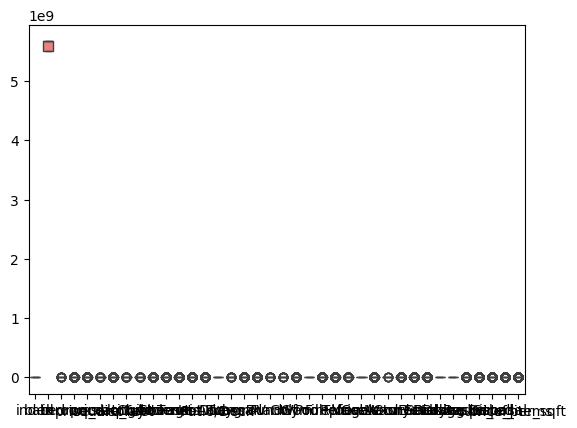

In [484]:
sns.boxplot(outliersdata_2)

In [485]:
numcoll = ["bedrooms","square_feet","bathrooms","price_display"]

In [486]:
outliersdata_1 = outliersdata_1[outliersdata_1['bedrooms'] > 0]

In [487]:
outliersdata_1 = outliersdata_1[outliersdata_1['bathrooms'] > 0]

In [488]:
outliersdata_1 = outliersdata_1[(outliersdata_1.square_feet/outliersdata_1.bedrooms>250)]

<Axes: >

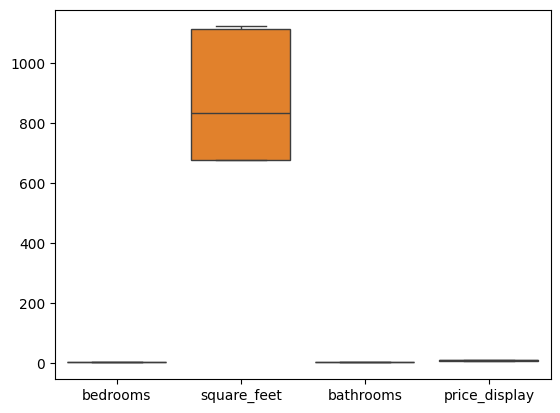

In [489]:
sns.boxplot(outliersdata)

In [490]:
outliersdata=outliersdata_1[numcoll]

In [491]:
theoutlierindex =detect_outliers_iqr(outliersdata)

In [492]:
theoutlierindex
for key in theoutlierindex.keys() :
    print(f"{key} the len = {len(theoutlierindex[key])}")

bedrooms the len = 442
square_feet the len = 555
bathrooms the len = 63
price_display the len = 178


In [493]:
Q3 = outliersdata["square_feet"].quantile(0.75)
Q1 = outliersdata["square_feet"].quantile(0.25)

In [494]:
outliersdata.loc[outliersdata["square_feet"] > Q3, "square_feet"] =  Q3
outliersdata.loc[outliersdata["square_feet"] < Q1, "square_feet"] =  Q1

C:\Users\Moaaz Osama\AppData\Local\Temp\ipykernel_11772\1162917000.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '677.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  outliersdata.loc[outliersdata["square_feet"] < Q1, "square_feet"] =  Q1


In [495]:
Q3 = outliersdata["bedrooms"].quantile(0.75)
Q1 = outliersdata["bedrooms"].quantile(0.25)

In [496]:
outliersdata.loc[outliersdata["bedrooms"] > Q3, "bedrooms"] =  Q3
outliersdata.loc[outliersdata["bedrooms"] < Q1, "bedrooms"] =  Q1

In [497]:
Q3 = outliersdata["price_display"].quantile(0.75)
Q1 = outliersdata["price_display"].quantile(0.25)

In [498]:
outliersdata.loc[outliersdata["price_display"] > Q3, "price_display"] =  Q3
outliersdata.loc[outliersdata["price_display"] < Q1, "price_display"] =  Q1

<Axes: >

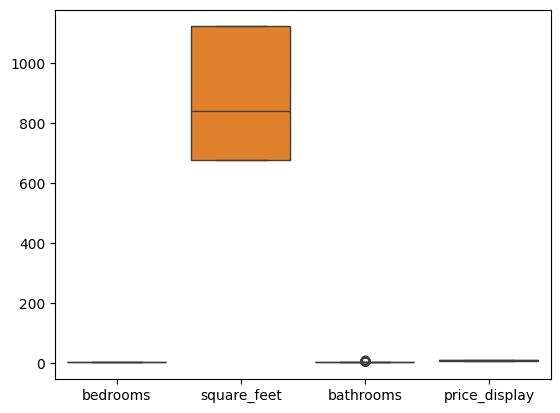

In [499]:
sns.boxplot(outliersdata)

In [500]:
outliersdata=outliersdata.drop(theoutlierindex['bathrooms'])

<Axes: >

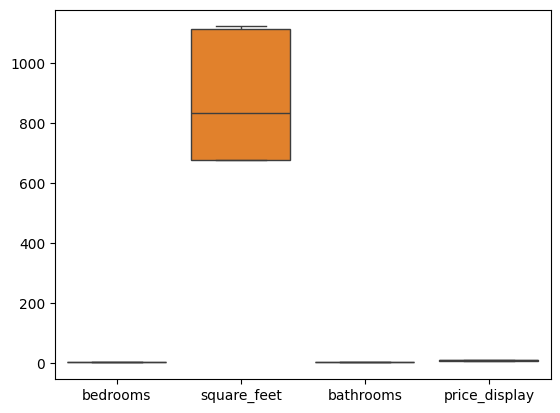

In [501]:
sns.boxplot(outliersdata)

In [502]:
outliersdata_1[numcoll]=outliersdata[numcoll]

In [503]:
outliersdata_1=outliersdata_1.dropna()

In [504]:
outliersdata_1.isna().sum()

index                 0
id                    0
category              0
title                 0
body                  0
amenities             0
bathrooms             0
bedrooms              0
currency              0
fee                   0
has_photo             0
pets_allowed          0
price                 0
price_display         0
price_type            0
square_feet           0
address               0
cityname              0
state                 0
latitude              0
longitude             0
source                0
time                  0
Clubhouse             0
Storage               0
Tennis                0
Internet Access       0
Hot Tub               0
Patio/Deck            0
Doorman               0
Playground            0
TV                    0
Alarm                 0
Golf                  0
Gym                   0
Pool                  0
Wood Floors           0
Fireplace             0
View                  0
Refrigerator          0
AC                    0
Luxury          

In [505]:
outliersdata_1["bathrooms"].value_counts()

bathrooms
1.0    5538
2.0    2430
3.0     220
Name: count, dtype: int64

### **Encoding**

In [506]:
encodingdata=outliersdata_2.copy()

In [507]:
encodingdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6651 entries, 0 to 6848
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               6651 non-null   int64         
 1   id                  6651 non-null   int64         
 2   category            6651 non-null   category      
 3   title               6651 non-null   category      
 4   body                6651 non-null   category      
 5   amenities           6651 non-null   object        
 6   bathrooms           6651 non-null   float64       
 7   bedrooms            6651 non-null   float64       
 8   currency            6651 non-null   category      
 9   fee                 6651 non-null   category      
 10  has_photo           6651 non-null   category      
 11  pets_allowed        6651 non-null   category      
 12  price               6651 non-null   int64         
 13  price_display       6651 non-null   float64       
 1

In [508]:
targetencode=["cityname","amenities","address"]

In [509]:
encoder = ce.TargetEncoder(cols=targetencode)

In [510]:
encodingdata[targetencode] = encoder.fit_transform(encodingdata[targetencode], encodingdata["price_display"])

In [511]:
encodingdata = pd.get_dummies(encodingdata, columns=['pets_allowed'], prefix='pets')

In [512]:
targetencode2=["category","title","body","currency","fee","has_photo","price_type","state","time","source"]

In [513]:
label_encoder = LabelEncoder()
for col in targetencode2:
    encodingdata[col] = label_encoder.fit_transform(encodingdata[col])

In [514]:
encodingdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6651 entries, 0 to 6848
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               6651 non-null   int64  
 1   id                  6651 non-null   int64  
 2   category            6651 non-null   int32  
 3   title               6651 non-null   int32  
 4   body                6651 non-null   int32  
 5   amenities           6651 non-null   float64
 6   bathrooms           6651 non-null   float64
 7   bedrooms            6651 non-null   float64
 8   currency            6651 non-null   int32  
 9   fee                 6651 non-null   int32  
 10  has_photo           6651 non-null   int32  
 11  price               6651 non-null   int64  
 12  price_display       6651 non-null   float64
 13  price_type          6651 non-null   int32  
 14  square_feet         6651 non-null   int64  
 15  address             6651 non-null   float64
 16  cityname   

### **Duplicates**

In [515]:
df_no_duplicates = encodingdata.drop_duplicates()

In [516]:
encodingdata.head(9000)

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Parking,Dishwasher,Garbage Disposal,Basketball,Gated,sum_of_items,price_per_sqft,pets_Cats,"pets_Cats,Dogs",pets_Dogs
0,1637,5668611668,0,3851,1954,7.133694,1.0,2.0,0,0,...,1,1,0,0,0,9,241025.641026,False,True,False
1,2490,5668616803,0,4158,5200,7.142572,1.0,2.0,0,0,...,0,1,0,0,0,3,176054.421769,False,True,False
2,2560,5664597913,0,5150,2493,7.186387,2.0,2.0,0,0,...,1,0,0,0,0,1,187835.420394,False,True,False
3,3053,5664597733,0,4372,2212,7.186387,2.0,3.0,0,0,...,1,0,0,0,0,1,191798.941799,False,False,True
4,4324,5668624330,0,5725,5011,7.181820,1.0,2.0,0,0,...,0,1,1,0,0,5,211666.666667,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6844,8983,5664597187,0,5037,2019,7.186387,1.0,2.0,0,0,...,1,0,0,0,0,1,142105.263158,False,True,False
6845,8985,5668615625,0,2002,3339,7.186387,1.0,1.0,0,0,...,1,0,0,0,0,1,205035.971223,False,True,False
6846,8987,5668611444,0,5899,5758,7.129678,2.0,2.0,0,0,...,1,1,0,0,0,6,125962.487660,False,True,False
6847,8989,5668634559,0,2350,3932,7.186387,1.0,1.0,0,0,...,1,0,0,0,0,1,218965.517241,False,True,False


### **Normalization** 

In [517]:
norm_data = df_no_duplicates.copy()

In [518]:
minmax=["square_feet"]

In [519]:
scaler = MinMaxScaler()
norm_data['square_feet'] = scaler.fit_transform(norm_data[['square_feet']])

In [520]:
phaseTwo_data=norm_data.copy()

In [521]:
phaseTwo_data

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Parking,Dishwasher,Garbage Disposal,Basketball,Gated,sum_of_items,price_per_sqft,pets_Cats,"pets_Cats,Dogs",pets_Dogs
0,1637,5668611668,0,3851,1954,7.133694,1.0,2.0,0,0,...,1,1,0,0,0,9,241025.641026,False,True,False
1,2490,5668616803,0,4158,5200,7.142572,1.0,2.0,0,0,...,0,1,0,0,0,3,176054.421769,False,True,False
2,2560,5664597913,0,5150,2493,7.186387,2.0,2.0,0,0,...,1,0,0,0,0,1,187835.420394,False,True,False
3,3053,5664597733,0,4372,2212,7.186387,2.0,3.0,0,0,...,1,0,0,0,0,1,191798.941799,False,False,True
4,4324,5668624330,0,5725,5011,7.181820,1.0,2.0,0,0,...,0,1,1,0,0,5,211666.666667,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6844,8983,5664597187,0,5037,2019,7.186387,1.0,2.0,0,0,...,1,0,0,0,0,1,142105.263158,False,True,False
6845,8985,5668615625,0,2002,3339,7.186387,1.0,1.0,0,0,...,1,0,0,0,0,1,205035.971223,False,True,False
6846,8987,5668611444,0,5899,5758,7.129678,2.0,2.0,0,0,...,1,1,0,0,0,6,125962.487660,False,True,False
6847,8989,5668634559,0,2350,3932,7.186387,1.0,1.0,0,0,...,1,0,0,0,0,1,218965.517241,False,True,False


In [522]:
phaseTwo_data.describe()

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Cable or Satellite,Washer Dryer,Elevator,Parking,Dishwasher,Garbage Disposal,Basketball,Gated,sum_of_items,price_per_sqft
count,6651.000000,6.651000e+03,6651.000000,6651.000000,6651.000000,6651.000000,6651.000000,6651.000000,6651.0,6651.0,...,6651.000000,6651.000000,6651.000000,6651.000000,6651.000000,6651.000000,6651.000000,6651.000000,6651.000000,6651.000000
mean,4493.907533,5.620453e+09,0.000150,3044.095474,3313.745903,7.139400,1.316945,1.680198,0.0,0.0,...,0.173959,0.113817,0.058788,0.715531,0.335288,0.122688,0.033078,0.049917,3.582770,159962.230995
std,2601.776766,7.160956e+07,0.012262,1825.567022,1918.324181,0.075154,0.509146,0.839153,0.0,0.0,...,0.379103,0.317613,0.235245,0.451195,0.472127,0.328104,0.178853,0.217790,3.167485,71459.971951
min,1.000000,5.508654e+09,0.000000,0.000000,0.000000,6.913296,1.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,56374.674761
25%,2261.500000,5.509222e+09,0.000000,1411.500000,1650.500000,7.097837,1.000000,1.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,112110.765423
50%,4474.000000,5.668251e+09,0.000000,3074.000000,3313.000000,7.158609,1.000000,2.000000,0.0,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,145000.000000
75%,6745.500000,5.668625e+09,0.000000,4592.500000,4975.500000,7.186387,2.000000,2.000000,0.0,0.0,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.000000,189300.533491
max,8999.000000,5.668643e+09,1.000000,6212.000000,6629.000000,7.382443,5.000000,6.000000,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,727272.727273


In [523]:
phaseTwo_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6651 entries, 0 to 6848
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               6651 non-null   int64  
 1   id                  6651 non-null   int64  
 2   category            6651 non-null   int32  
 3   title               6651 non-null   int32  
 4   body                6651 non-null   int32  
 5   amenities           6651 non-null   float64
 6   bathrooms           6651 non-null   float64
 7   bedrooms            6651 non-null   float64
 8   currency            6651 non-null   int32  
 9   fee                 6651 non-null   int32  
 10  has_photo           6651 non-null   int32  
 11  price               6651 non-null   int64  
 12  price_display       6651 non-null   float64
 13  price_type          6651 non-null   int32  
 14  square_feet         6651 non-null   float64
 15  address             6651 non-null   float64
 16  cityname   

In [524]:
phaseTwo_data.isna().sum()

index                 0
id                    0
category              0
title                 0
body                  0
amenities             0
bathrooms             0
bedrooms              0
currency              0
fee                   0
has_photo             0
price                 0
price_display         0
price_type            0
square_feet           0
address               0
cityname              0
state                 0
latitude              0
longitude             0
source                0
time                  0
Clubhouse             0
Storage               0
Tennis                0
Internet Access       0
Hot Tub               0
Patio/Deck            0
Doorman               0
Playground            0
TV                    0
Alarm                 0
Golf                  0
Gym                   0
Pool                  0
Wood Floors           0
Fireplace             0
View                  0
Refrigerator          0
AC                    0
Luxury                0
Cable or Satelli

## **Phase Three**

### **Correlation**

In [525]:
correlation_data=phaseTwo_data.copy()

In [526]:
correlation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6651 entries, 0 to 6848
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               6651 non-null   int64  
 1   id                  6651 non-null   int64  
 2   category            6651 non-null   int32  
 3   title               6651 non-null   int32  
 4   body                6651 non-null   int32  
 5   amenities           6651 non-null   float64
 6   bathrooms           6651 non-null   float64
 7   bedrooms            6651 non-null   float64
 8   currency            6651 non-null   int32  
 9   fee                 6651 non-null   int32  
 10  has_photo           6651 non-null   int32  
 11  price               6651 non-null   int64  
 12  price_display       6651 non-null   float64
 13  price_type          6651 non-null   int32  
 14  square_feet         6651 non-null   float64
 15  address             6651 non-null   float64
 16  cityname   

In [527]:
features = correlation_data.drop(columns=["price_display"])
transformed_data = pd.concat([features, correlation_data["price_display"]], axis=1)

In [528]:
from scipy.stats import boxcox
#transformed_data["square_feet"] = np.power(transformed_data["square_feet"],2)
transformed_data['square_feet_log'] = np.log(transformed_data['square_feet'])
transformed_data['square_feet_sqrt'] = np.sqrt(transformed_data['square_feet'])
#transformed_data['square_feet_exp'] = np.exp(transformed_data['square_feet'])




max_value = transformed_data['square_feet'].max()
min_value = transformed_data['square_feet'].min()

if max_value > 709:  # Maximum value for safe exponentiation in numpy
    transformed_data['square_feet'] = transformed_data['square_feet'].apply(lambda x: 709 if x > 709 else x)
if min_value < -709:  # Minimum value for safe exponentiation in numpy
    transformed_data['square_feet'] = transformed_data['square_feet'].apply(lambda x: -709 if x < -709 else x)

# Exponential transformation
transformed_data['square_feet_exp'] = np.exp(transformed_data['square_feet'])

D:\software2\anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [529]:
transformed_data["square_feet"] 

0       0.153162
1       0.241686
2       0.421077
3       0.605621
4       0.318970
          ...   
6844    0.342389
6845    0.288056
6846    0.371897
6847    0.169087
6848    0.396721
Name: square_feet, Length: 6651, dtype: float64

In [530]:
features = transformed_data.drop(columns=["price_display"])
transformed_data = pd.concat([features, correlation_data["price_display"]], axis=1)

In [531]:
#sns.pairplot(transformed_data)

In [532]:
#sns.pairplot(correlation_data)

In [533]:
correlation_data=transformed_data

In [534]:
corr_matrix=correlation_data.corr()

<Axes: >

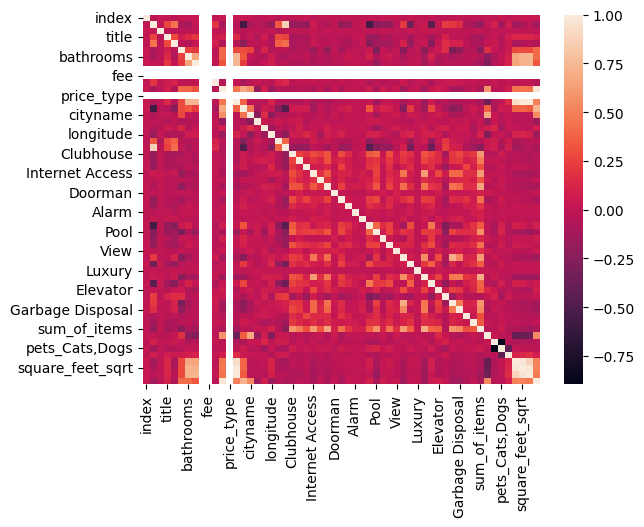

In [535]:
sns.heatmap(corr_matrix)

In [536]:
corr_matrix

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Gated,sum_of_items,price_per_sqft,pets_Cats,"pets_Cats,Dogs",pets_Dogs,square_feet_log,square_feet_sqrt,square_feet_exp,price_display
index,1.000000,-0.007552,0.017115,-0.000393,-0.007973,0.027430,0.018820,0.035467,NaN,NaN,...,-0.007134,-0.007920,0.007836,-0.009965,0.009277,-0.000559,0.030016,0.028275,0.022611,0.034314
id,-0.007552,1.000000,0.007306,0.266714,0.443278,-0.071822,-0.108096,0.009866,NaN,NaN,...,-0.126673,-0.188831,0.006852,0.103806,-0.124144,0.067390,-0.135724,-0.098372,-0.020145,-0.132660
category,0.017115,0.007306,1.000000,-0.019247,-0.016492,-0.016740,-0.007634,0.004674,NaN,NaN,...,-0.002811,0.009359,-0.014498,-0.002820,0.003151,-0.001336,0.000384,-0.001171,-0.003118,-0.021235
title,-0.000393,0.266714,-0.019247,1.000000,0.286909,0.077105,0.141435,0.215266,NaN,NaN,...,-0.089330,-0.127944,-0.022216,0.022736,-0.052148,0.070641,0.127681,0.140922,0.124416,0.087435
body,-0.007973,0.443278,-0.016492,0.286909,1.000000,-0.017938,-0.065241,0.012362,NaN,NaN,...,-0.087974,-0.081824,0.016827,0.040494,-0.055550,0.042237,-0.103408,-0.076186,-0.026107,-0.080089
amenities,0.027430,-0.071822,-0.016740,0.077105,-0.017938,1.000000,0.238362,0.208587,NaN,NaN,...,-0.037287,-0.243619,0.171604,0.015781,-0.039198,0.055755,0.280900,0.291698,0.276282,0.410355
bathrooms,0.018820,-0.108096,-0.007634,0.141435,-0.065241,0.238362,1.000000,0.654345,NaN,NaN,...,-0.011155,-0.077717,-0.216695,-0.070128,0.020314,0.096776,0.662216,0.724788,0.727806,0.410271
bedrooms,0.035467,0.009866,0.004674,0.215266,0.012362,0.208587,0.654345,1.000000,NaN,NaN,...,-0.059922,-0.123924,-0.278412,-0.047740,-0.002050,0.101437,0.651575,0.716673,0.733175,0.333108
currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [537]:
corr_matrix['price_display'].sort_values(ascending=False)

price_display         1.000000
price                 0.963975
address               0.719411
price_per_sqft        0.545201
cityname              0.541820
square_feet_sqrt      0.506366
square_feet_log       0.499151
square_feet           0.491859
square_feet_exp       0.470408
amenities             0.410355
bathrooms             0.410271
bedrooms              0.333108
Gym                   0.093975
title                 0.087435
latitude              0.078726
pets_Dogs             0.078195
Elevator              0.075689
Wood Floors           0.064074
Washer Dryer          0.050207
View                  0.034664
index                 0.034314
TV                    0.025866
Doorman               0.024432
Parking               0.017933
Luxury                0.013143
Hot Tub               0.011899
Alarm                 0.011197
AC                    0.009729
Gated                 0.004017
Fireplace             0.003740
Golf                 -0.001854
pets_Cats,Dogs       -0.006960
Storage 

### **Feature Extraction**

In [538]:
FeatureExtraction_data=correlation_data.copy()

In [539]:
top_columns=[]

In [540]:
top_columns+=corr_matrix[corr_matrix['price'] >= 0.2]['price'].index.tolist()

In [541]:
top_columns+=corr_matrix[corr_matrix['price'] <= -0.15]['price'].index.tolist()

In [542]:
top_columns

['amenities',
 'bathrooms',
 'bedrooms',
 'price',
 'square_feet',
 'address',
 'cityname',
 'price_per_sqft',
 'square_feet_log',
 'square_feet_sqrt',
 'square_feet_exp',
 'price_display',
 'state',
 'longitude']

In [543]:
FeatureExtraction_data=FeatureExtraction_data[top_columns]

In [544]:
FeatureExtraction_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6651 entries, 0 to 6848
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amenities         6651 non-null   float64
 1   bathrooms         6651 non-null   float64
 2   bedrooms          6651 non-null   float64
 3   price             6651 non-null   int64  
 4   square_feet       6651 non-null   float64
 5   address           6651 non-null   float64
 6   cityname          6651 non-null   float64
 7   price_per_sqft    6651 non-null   float64
 8   square_feet_log   6651 non-null   float64
 9   square_feet_sqrt  6651 non-null   float64
 10  square_feet_exp   6651 non-null   float64
 11  price_display     6651 non-null   float64
 12  state             6651 non-null   int32  
 13  longitude         6651 non-null   float64
dtypes: float64(12), int32(1), int64(1)
memory usage: 753.4 KB


In [545]:
FeatureExtraction_data=FeatureExtraction_data.drop(columns=["price","price_per_sqft","square_feet_log","square_feet_exp","square_feet"],axis=1)

In [546]:
FeatureExtraction_data

,amenities,bathrooms,bedrooms,address,cityname,square_feet_sqrt,price_display,state,longitude
0,7.133694,1.0,2.0,7.133694,7.192936,0.391359,7.182352,44,-77.1257
1,7.142572,1.0,2.0,7.131501,7.192936,0.491616,7.165493,44,-77.1072
2,7.186387,2.0,2.0,7.194499,7.192936,0.648905,7.649693,44,-77.1072
3,7.186387,2.0,3.0,7.236495,7.192936,0.778216,7.972466,44,-77.1072
4,7.181820,1.0,2.0,7.181820,7.192936,0.564774,7.552237,44,-77.1072
...,...,...,...,...,...,...,...,...,...
6844,7.186387,1.0,2.0,7.137013,7.106917,0.585140,7.207860,22,-93.4704
6845,7.186387,1.0,1.0,7.167769,7.106917,0.536709,7.444249,4,-117.8844
6846,7.129678,2.0,2.0,7.129678,7.106917,0.609834,7.151485,42,-97.2167
6847,7.186387,1.0,1.0,7.129065,7.106917,0.411201,7.146772,46,-122.4121


In [547]:
FeatureExtraction_data.columns

Index(['amenities', 'bathrooms', 'bedrooms', 'address', 'cityname',
       'square_feet_sqrt', 'price_display', 'state', 'longitude'],
      dtype='object')

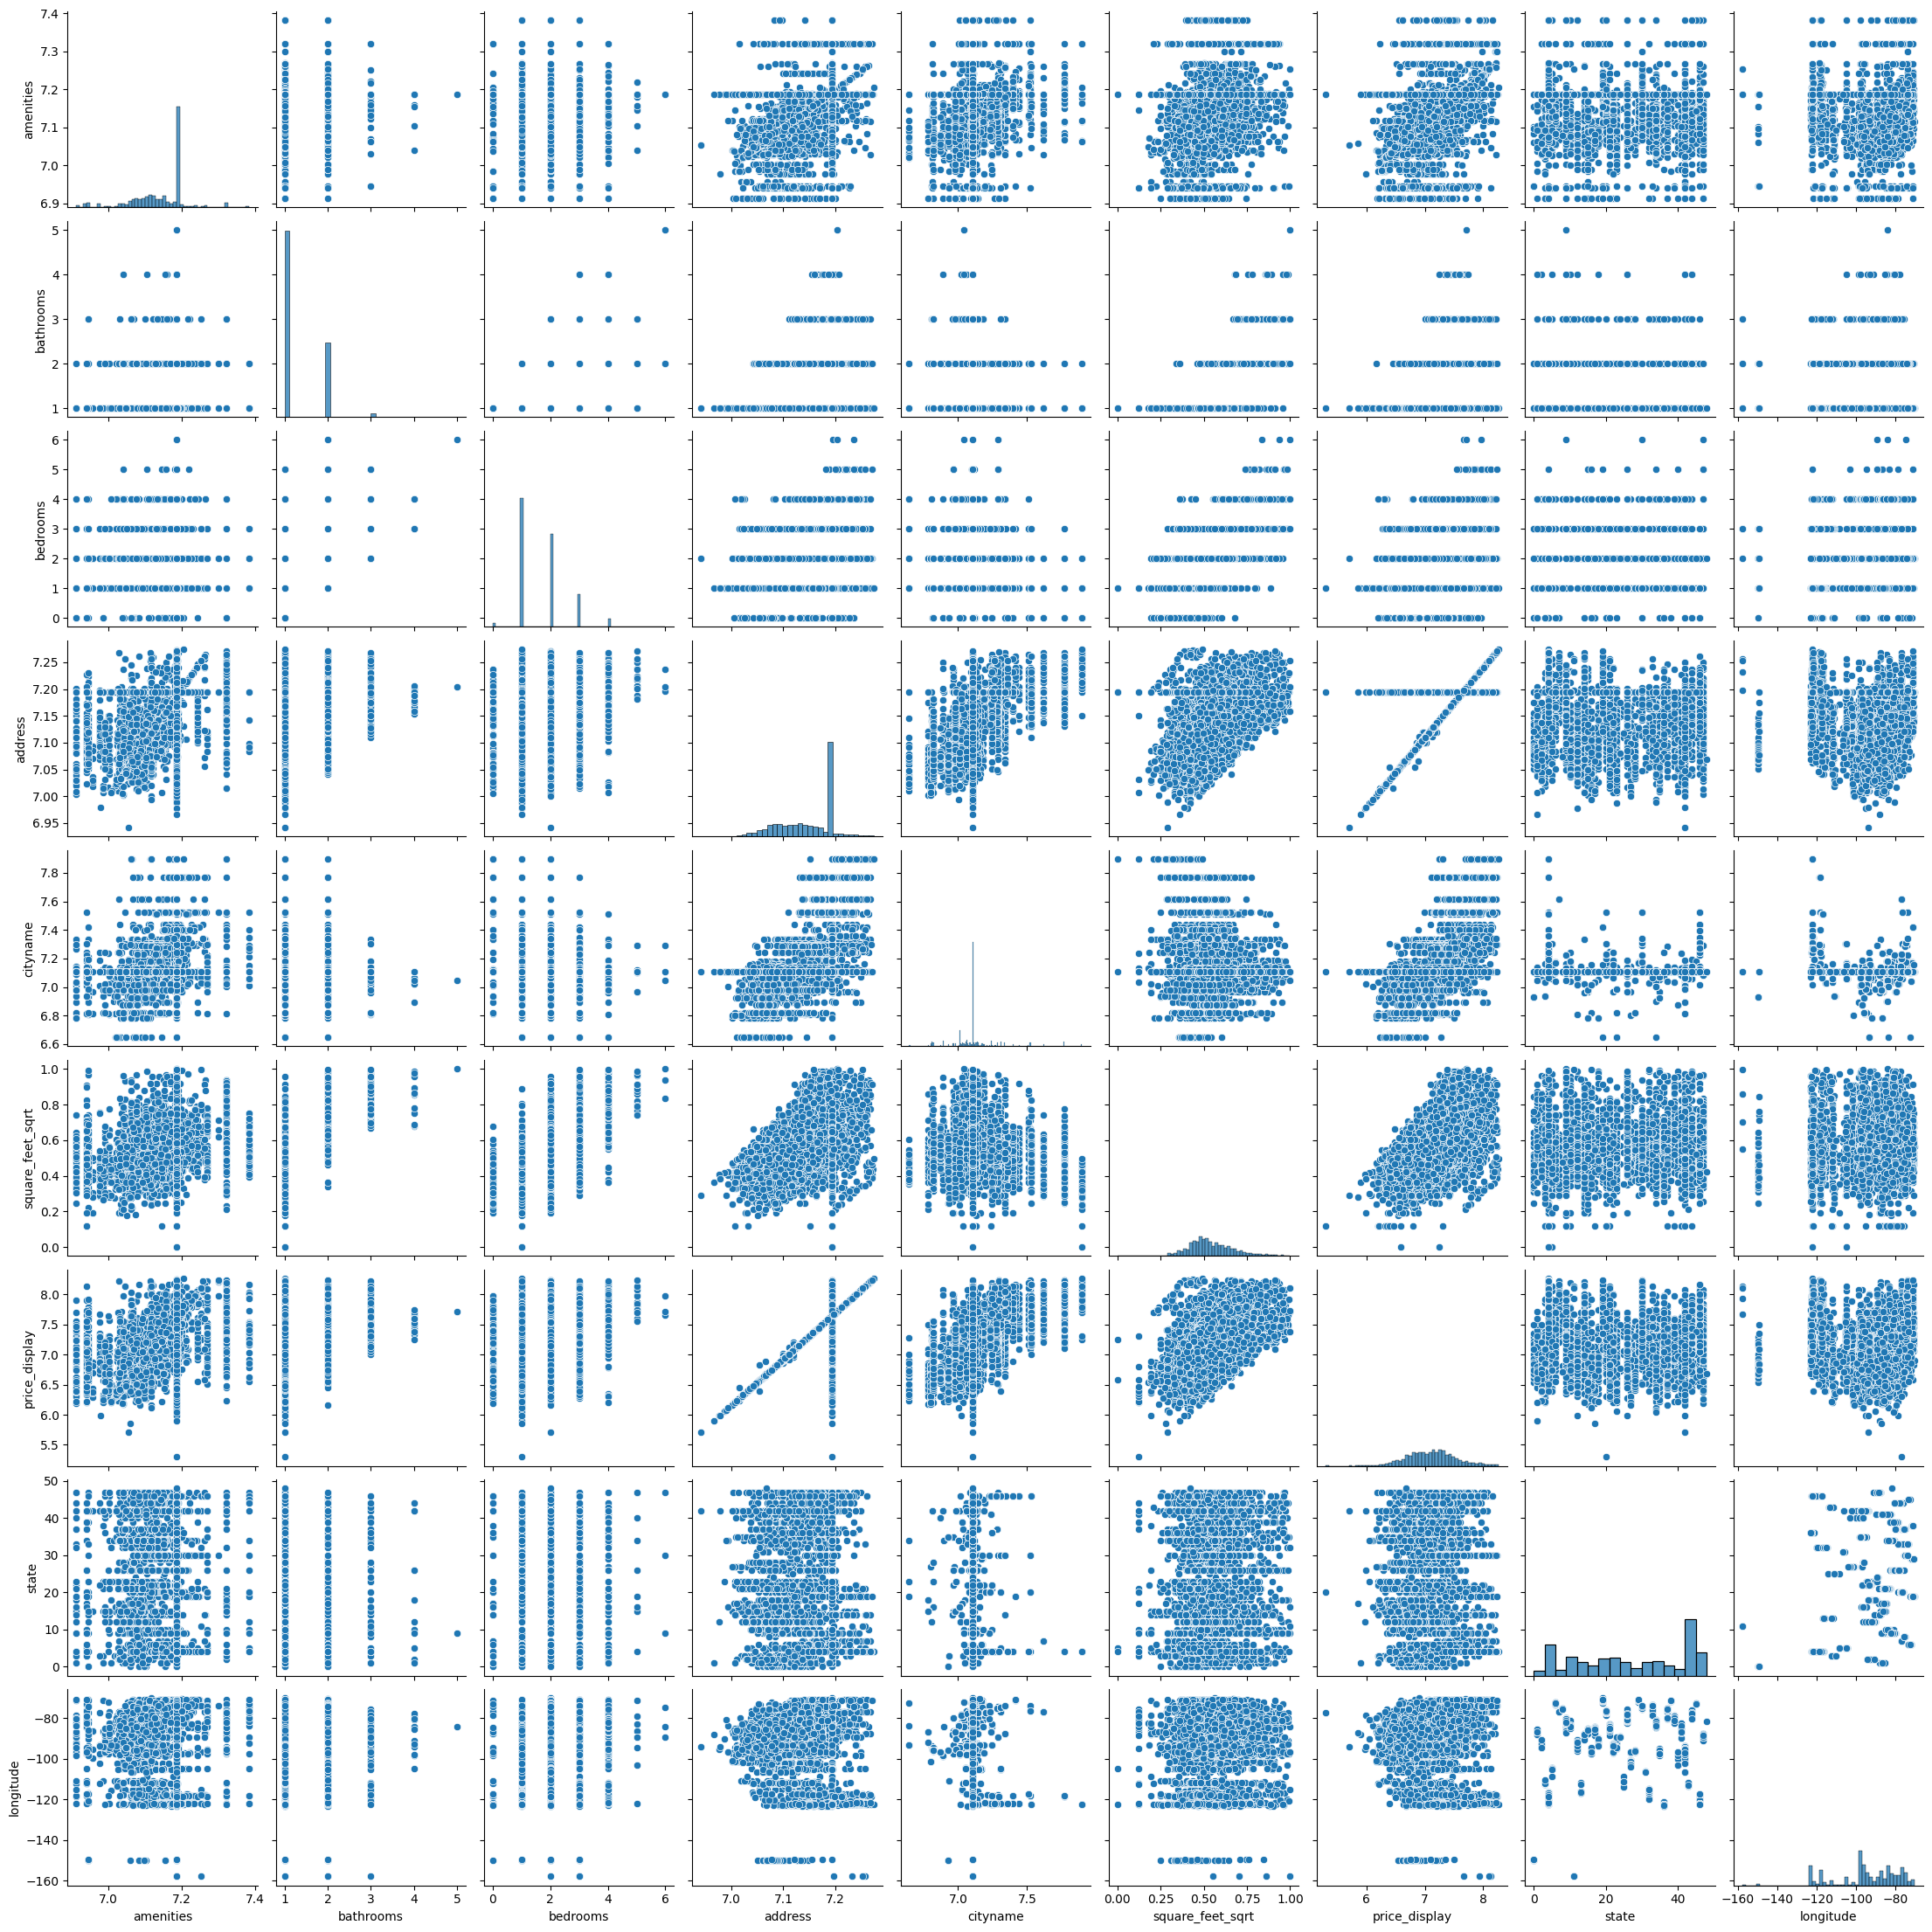

In [548]:
sns.pairplot(FeatureExtraction_data)

### **Models**

#### **LinearRegression**

In [549]:
models_data = FeatureExtraction_data.copy()

In [550]:
X = models_data.drop(columns=["price_display"])
Y = models_data['price_display'] 

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,random_state=30)

In [552]:
reg = LinearRegression().fit(X_train, y_train)

In [553]:
y_predict=reg.predict(X_test)

In [554]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predict))
print('accuracy',r2_score(y_test,y_predict))

Mean squared error: 0.05
accuracy 0.704055966870573


In [555]:
reg.score(X_test,y_test)

0.704055966870573

#### **PolynomialFeatures**

In [556]:
polynomialFeatures_data= FeatureExtraction_data.copy()

In [557]:
x = polynomialFeatures_data.drop(columns=["price_display"])
y = polynomialFeatures_data['price_display'] 

In [558]:
degree = 3

In [559]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30,shuffle=True,random_state=120)

In [560]:
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_train)

In [561]:
model = LinearRegression().fit(X_poly, y_train)

In [562]:
X_test_poly = poly_features.transform(X_test)
y_test_pred = model.predict(X_test_poly)

In [563]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_pred))
print('accuracy',r2_score(y_test,y_test_pred))

Mean squared error: 0.02
accuracy 0.8488367163289587


#### **RandomForestRegressor**

In [564]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Define features (X) and target variable (y)
X = FeatureExtraction_data.drop(columns=['price_display'])
y = FeatureExtraction_data['price_display']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=120)

# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Mean Squared Error: 0.010305871347792438
Root Mean Squared Error: 0.10151783758430061
R-squared: 0.9349203166667022


#### **GradientBoostingRegressor**

In [565]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Define features (X) and target variable (y)
X = FeatureExtraction_data.drop(columns=['price_display'])
y = FeatureExtraction_data['price_display']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Gradient Boosting Regressor model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Mean Squared Error: 0.014590171473256735
Root Mean Squared Error: 0.12078978215584601
R-squared: 0.9051264170350087


#### **StandardScaler**

In [566]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVR model
svr_model = SVR(kernel='rbf')  # RBF kernel is commonly used, but you can experiment with others

# Train the model
svr_model.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = svr_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.01961859858031182
R-squared Score: 0.8753375352459645


#### **DecisionTreeRegressor**

In [567]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regression model
tree_model = DecisionTreeRegressor(random_state=42)

# Train the model
tree_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = tree_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.018605895540393613
R-squared Score: 0.8817725543684212


#### **StandardScaler**

In [568]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features if needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Lasso model
lasso_model = Lasso(alpha=0.001)  # You can adjust the regularization strength by changing alpha

# Train the model
lasso_model.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = lasso_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)

Mean Squared Error: 0.053381172785687464
R-squared Score: 0.6608000034414754


#### **Ridge**

In [569]:
# Define features (X) and target variable (y)
X = FeatureExtraction_data.drop(columns=['price_display'])
y = FeatureExtraction_data['price_display']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Adjusting alpha for Ridge Regression
from sklearn.linear_model import Ridge
alpha_values = [0.1, 1, 10,20,0.00001]
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    predictions = ridge.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"For alpha={alpha}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (RÂ²) Score: {r2}")

For alpha=0.1:
Mean Squared Error (MSE): 0.05336317702552416
R-squared (RÂ²) Score: 0.6609143539037623
For alpha=1:
Mean Squared Error (MSE): 0.05334380027235478
R-squared (RÂ²) Score: 0.6610374796101748
For alpha=10:
Mean Squared Error (MSE): 0.05682771801465097
R-squared (RÂ²) Score: 0.6388996204263486
For alpha=20:
Mean Squared Error (MSE): 0.060787814205742564
R-squared (RÂ²) Score: 0.6137359804332263
For alpha=1e-05:
Mean Squared Error (MSE): 0.05338017934137059
R-squared (RÂ²) Score: 0.6608063160848903
